In [75]:
!pip install nmrglue
!pip install peakutils
!pip install scikit-ued
!pip install pybaselines
from sys import path_hooks
import pathlib as pth
import numpy as np
import nmrglue as ng
from matplotlib import pyplot as plt
import pandas as pd
import os
import skued
import pybaselines
from itertools import product
from scipy.linalg import hadamard

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.7/225.7 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.9/257.9 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.2 MB/s eta 0:00:00
  Created wheel for pycifrw: filename=PyCifRW-4.4.6-cp310-cp310-linux_x86_64.whl size=160870 sha256=81dabc41db452e76f9c2cda52ae80cd684e8f80e7640223007658a5683276ccb
  Stored in directory: /root/.cache/pip/wheels/2b/6e/4e/808875fdfc5b8

In [289]:
class Operator_basis:
    def __init__(self, N):
        self.N = N
        self.operators = ['Id', '-Id', 'sigma_x', '-sigma_x', 'sigma_y', '-sigma_y', 'sigma_z', '-sigma_z']
        self.operator_dict = {
            'Id': np.array([[1, 0], [0, 1]]),
            '-Id': np.array([[-1, 0], [0, -1]]),
            'sigma_x': np.array([[0, 1], [1, 0]]),
            '-sigma_x': -np.array([[0, 1], [1, 0]]),
            'sigma_y': np.array([[0, -1j], [1j, 0]]),
            '-sigma_y': -np.array([[0, -1j], [1j, 0]]),
            'sigma_z': np.array([[1, 0], [0, -1]]),
            '-sigma_z': -np.array([[1, 0], [0, -1]])
        }
        self.basis_operators = self.generate_basis_operators()
        self.transition_table = {'1x': '1', '1y': '1', '1z': '1', '11': '1', 'x1': 'x',
                                 'xx': 'x', 'xy': 'z', 'y1': 'y', 'yx': '-z','yy': 'y',
                                 'z1': 'z', 'zx': 'y', 'zy': '-x'
                                 }

    def generate_basis_operators(self):
        combinations = product(self.operators, repeat=self.N)
        basis_operators = {}
        for combo in combinations:
            if combo[0] == 'Id':
                result = self.operator_dict['Id']
            else:
                result = 2 * self.operator_dict[combo[0]]
            k = 0

            for i in range(len(combo)-1):
                result = np.kron(result, self.operator_dict[combo[i+1]])
                if combo[i+1] != 'Id':
                    k += 1
            result *= (2 ** k)
            name = self.create_operator_name(combo)
            basis_operators[tuple(name)] = result
        return basis_operators

    def create_operator_name(self, combo):
        name_parts = ['1'] * self.N
        for index, op in enumerate(combo):
            if op == 'Id':
                name_parts[index] = '1'
            elif op == '-Id':
                name_parts[index] = '-1'
            else:
                operator_symbol = op[-1]
                if op.startswith('-'):
                    operator_symbol = '-' + operator_symbol
                name_parts[index] = operator_symbol
        return name_parts

    def get_operator(self, name):
        return self.basis_operators.get(tuple(name), None)

    def apply_pulse(self, name, pulse):
        new_name_parts = []
        for j in range(self.N):
            for (header, pulse_char) in zip(name[j], list(pulse)[j]):
                header_pair = header + pulse_char
                new_symbol = self.transition_table.get(header_pair)
                new_name_parts.append(new_symbol)
        return tuple(new_name_parts)


class SpectraSequence:
    def __init__(self, file_path, sequence, order = False, apply_mask=True):
        self.file_path = file_path
        self.df = pd.read_csv(os.path.join(self.file_path, 'dict.csv'))
        self.sequence = list(sequence)
        self.data = []
        self.dict_info = {
            'peak_widths': [], 'centers' : [], 'borders': [], 'multiplet_types': [],
            'overlaps': [], 'acquisition_time': [], 'order': []
            }
        self.spectras = []
        self.freqs = []
        self.areas = []
        self.id = {
            '1': [], 'y': [], 'x': []
            }
        if not isinstance(self.file_path, str):
            raise TypeError(f"Ожидался тип str для file_path, получено {type(self.file_path)}")
        if not isinstance(self.sequence, list):
            raise TypeError(f"Ожидался тип list для sequence, получено {type(self.sequence)}")
        self.read_files()
        self.size = [len(self.sequence), len(self.data[0]), [len(self.data[i][0]) for i in range(len(self.data))]]
        self.phases = self.proper_phases()
        self.perform_fourier()
        self.identify()
        self.correct_baselines()
        self.spectras, self.freqs = self.apply_mask(apply_mask)
        self.split_peaks()
        if order:
            self.dict_info['order'] = self.distribute_idx_by_order(order)
        if not order and self.indices_are_consistent():
            self.dict_info['order'] = self.restore_order_from_idx()
        self.rho = np.zeros((2**self.size[0], 2**self.size[0]))

    def read_files(self):
        for seq in self.sequence:
            tmp = os.path.join(self.file_path, seq)
            d, da = ng.varian.read(tmp)
            self.data.append(da)
            filtered_df = self.df[self.df['nucleus'] == seq]
            if filtered_df.empty:
                raise ValueError(f"Не удалось найти информацию для {seq} в файле dict.csv")
            self.dict_info['peak_widths'].append(filtered_df['peak_width'].values[0])
            self.dict_info['centers'].append(filtered_df['center'].values[0])
            self.dict_info['borders'].append(filtered_df['borders'].values[0])
            self.dict_info['multiplet_types'].append(filtered_df['multiplet_type'].values[0])
            self.dict_info['overlaps'].append(int(filtered_df['overlaps'].values[0]))
            self.dict_info['acquisition_time'].append(float(d['procpar']['at']['values'][0]))

    def proper_phases(self) -> list:
        tmp = []
        for i in range(self.size[0]):
            spectrum_unpr = np.fft.fft(self.data[i][0])
            spectrum, phase = ng.proc_autophase.autops(spectrum_unpr, 'acme', return_phases=True)
            tmp.append(phase)
        return tmp

    def identify(self):
        thresholds = [np.mean([max(np.real(spec)) for spec in spectra]) / 2 for spectra in self.spectras]
        noise_indices = [
            [idx for idx, max_val in enumerate([max(np.real(spec)) for spec in spectra]) if max_val < thresholds[i]]
            for i, spectra in enumerate(self.spectras)
        ]
        for i in range(self.size[0]):
            n_i = noise_indices[i]
            i_i = []
            r_i = []
            for j in range(self.size[1]-1):
                spec = self.spectras[i][j+1]
                spec_re = ((np.real(spec) / max(abs(np.real(spec))))*3)
                spec_im = ((np.imag(spec) / max(abs(np.imag(spec))))*3)
                if j+1 not in n_i and np.std(spec_re) > np.std(spec_im):
                    i_i.append(j+1)
                elif j+1 not in n_i and np.std(spec_re) < np.std(spec_im):
                    r_i.append(j+1)
            self.id['1'].append(n_i)
            self.id['y'].append(i_i)
            self.id['x'].append(r_i)

    def indices_are_consistent(self) -> bool:
        """Проверяем, что для каждого ядра количество элементов в '1', 'x' и 'y' одинаково"""
        for i, seq in enumerate(self.sequence):
            len_im_idx = len(self.id['y'][i])
            len_re_idx = len(self.id['x'][i])
            len_noize_idx = len(self.id['1'][i])
            if len_im_idx != len_re_idx or len_im_idx != len_noize_idx:
                raise ValueError(f"Автоматическое распознавание неудачно, восстановите порядок импульсов order для продолжения")
            else:
                return(True)

    def perform_fourier(self, apply_mask = True):
        for i in range(self.size[0]):
            freq = np.fft.fftfreq(len(self.data[i][0]), self.dict_info['acquisition_time'][i] / len(self.data[i][0]))
            self.freqs.append(freq)
            spec_set = []
            for j in range(self.size[1]):
                spectrum = np.fft.fft(self.data[i][j]) * np.exp(1j * 2 * np.pi / 360 * (self.phases[i][0]))
                spec_set.append(spectrum)
            self.spectras.append(spec_set)


    def prepare_spectras(self, k) -> list:
        p_s = []
        for i in range(self.size[0]):
            t = []
            for j in range(self.size[1]):
                if j in self.id['y'][i]:
                    corr = (-np.imag(self.spectras[i][j]) / max(-np.imag(self.spectras[i][j])) * k)**5
                    t.append(corr / max(corr))
                elif j in self.id['x'][i]:
                    corr = (np.real(self.spectras[i][j]) / max(np.real(self.spectras[i][j])) * k)**5
                    t.append(corr/max(corr))
                else:
                    t.append(self.spectras[i][j] / max(self.spectras[i][j]))
            p_s.append(t)
        return p_s

    def locate_peaks(self, k) -> list:
        p_s = self.prepare_spectras(k)
        peaks = []
        for i in range(self.size[0]):
            peaks_set = []
            for j in range(self.size[1]):
                peaks_subset = []
                if j not in self.id['1'][i] and j != 0:
                    loc_peaks = ng.analysis.peakpick.pick(p_s[i][j], 0.05, -0.2)
                    for k in range(len(loc_peaks)):
                        peaks_subset.append(int(loc_peaks[k][0]))
                else: peaks_subset.append(None)
                peaks_set.append(peaks_subset)
            peaks.append(peaks_set)
        return peaks




    def apply_mask(self, apply_mask) -> tuple:
        spectras = []
        frequencies = []
        for freq, spectrum_set, center, region in zip(self.freqs, self.spectras, self.dict_info['centers'], self.dict_info['borders']):
            if apply_mask:
                mask = (freq >= center - region) & (freq <= center + region)
                frequencies.append(freq[mask])
                spectras.append([spectrum[mask] for spectrum in spectrum_set])
            else:
                frequencies.append(freq)
                spectras.append(spectrum_set)
        return spectras, frequencies

    def calculate_areas(self, peaks) -> list:
        for i, freq_set in enumerate(self.freqs):
            areas = []
            dnu = abs(abs(freq_set[3]) - abs(freq_set[2]))
            width = int(self.dict_info['peak_widths'][i] / dnu)

            # fig, axs = plt.subplots(7, 4, figsize=(20, 35))
            # axs = axs.flatten()

            for j, spectrum in enumerate(self.spectras[i]):
                N = self.get_peak_count(self.dict_info['multiplet_types'][i])
                re_areas_ss = np.zeros(N)
                im_areas_ss = np.zeros(N)
                for peak_index, peak in enumerate(peaks[i][j]):
                    if peak is not None:
                        left = max(peak - width, 0)
                        right = min(peak + width, len(freq_set) - 1)
                        re_areas_ss[peak_index] += np.trapz(np.real(spectrum[left:right]), freq_set[left:right])
                        im_areas_ss[peak_index] += np.trapz(np.imag(spectrum[left:right]), freq_set[left:right])
                if j in self.id['y'][i]:
                    re_areas_ss = np.zeros(N)
                    # axs[j].plot(freq_set, -np.imag(spectrum))
                elif j in self.id['x'][i]:
                    # axs[j].plot(freq_set, np.real(spectrum))
                    im_areas_ss = np.zeros(N)
                # else:
                    # axs[j].plot(freq_set, np.real(spectrum))
                if self.dict_info['overlaps'][i] == 2:
                    re_areas_ss = np.array([
                        re_areas_ss[0]/2, re_areas_ss[0]/2,
                        re_areas_ss[1]/2, re_areas_ss[1]/2
                        ])
                    im_areas_ss = np.array([
                        im_areas_ss[0]/2, im_areas_ss[0]/2,
                        im_areas_ss[1]/2, im_areas_ss[1]/2
                        ])
                elif self.dict_info['overlaps'][i] == -2:
                    re_areas_ss = np.array([
                      re_areas_ss[0]/2, re_areas_ss[0]/2 + re_areas_ss[1]/2,
                      re_areas_ss[0]/2 + re_areas_ss[1]/2, re_areas_ss[1]/2
                      ])
                    im_areas_ss = np.array([
                        im_areas_ss[0]/2, im_areas_ss[0]/2 + im_areas_ss[1]/2,
                        im_areas_ss[0]/2 + im_areas_ss[1]/2, im_areas_ss[1]/2
                        ])
                areas.append(re_areas_ss + 1j* im_areas_ss)
            self.areas.append(areas)
            # plt.tight_layout()
            # plt.show()
        # return self.areas

    def get_peak_count(self, spectrum_type) -> int:
        if spectrum_type == 'singlet':
            return 1
        elif spectrum_type == 'doublet':
            return 2
        elif spectrum_type == 'triplet':
            return 3
        elif spectrum_type == 'quartet':
          return 4
        else:
            raise ValueError("Неизвестный тип спектра: " + spectrum_type[0])

    def distribute_idx_by_order(self, order) -> list:
        distribution = [[[], [], []] for _ in range(self.size[0])]
        for index, word in enumerate(order):
            for i in range(self.size[0]):
                char = word[i]
                if char == 'x':
                    distribution[i][0].append(index + 1)
                elif char == 'y':
                    distribution[i][1].append(index + 1)
                elif char == '1':
                    distribution[i][2].append(index + 1)
        return distribution

    def restore_order_from_idx(self) -> list:
        distribution = []
        for i in range(self.size[0]):
            dist = [self.id['x'][i], self.id['y'][i], self.id['1'][i]]
            distribution.append(dist)
        words = [""] * self.size[1]
        for i in range(self.size[0]):
            x_indices, y_indices, one_indices = distribution[i]
            for index in x_indices:
                words[index] += 'x'
            for index in y_indices:
                words[index] += 'y'
            for index in one_indices:
                words[index] += '1'
        return words

    def split_peaks(self):
        for i, overlap_type in enumerate(self.dict_info['overlaps']):
            if overlap_type == 22:
                self.dict_info['overlaps'][i] = 2
            elif overlap_type == 0:
                self.dict_info['overlaps'][i] = 1
            elif overlap_type == 121:
                self.dict_info['overlaps'][i] = -2

    def correct_baselines(self):
            for i in range(self.size[0]):
                for j in self.id['x'][i]:
                    bl = pybaselines.whittaker.drpls(np.real(self.spectras[i][j]))[0]
                    self.spectras[i][j] -= bl
                for k in self.id['y'][i]:
                    l = -np.imag(self.spectras[i][k])
                    bl = pybaselines.whittaker.drpls(l)[0]
                    self.spectras[i][k] += 1j*bl

    def apply_Hadamard(self):
        H = hadamard(2**2, dtype=complex)             #WIP
        for i in range(self.size[0]):
            for j in range(self.size[1]):
                self.areas[i][j] = 2 ** (1 - self.size[0]) * np.matmul(H, self.areas[i][j])

    def prepare_basis(self):
        basis = Operator_basis(self.size[0])
        initial_re_vectors = []
        initial_im_vectors = []
        part_comb = list(product(['1', 'z'], repeat=(self.size[0] - 1)))
        def generate_vectors(start_axis):
            full_comb = []
            for i in range(self.size[0]):
                nm_set = []
                for j in range(len(part_comb)):
                    t = [start_axis] + list(part_comb[j])
                    t = t[-i:] + t[:-i]
                    nm_set.append(tuple(t))
                full_comb.append(nm_set)
            return full_comb
        re_full_comb = generate_vectors('x')
        im_full_comb = generate_vectors('y')
        for i in range(self.size[0]):
            initial_re_vectors.append(np.array(re_full_comb[i][:4]))             #WIP
            initial_im_vectors.append(np.array(im_full_comb[i][:4]))             #WIP
        result = [initial_re_vectors, initial_im_vectors]
        return result

    def perform_tomography(self):
        vectors = self.prepare_basis()
        for i in range(self.size[0]):
            for j in range(self.size[1] - 1):
                for k in range(4):
                    self.rho = self.rho + basis.get_operator(basis.apply_pulse(vectors[0][i][k], self.dict_info['order'][j+1])) * np.real(self.areas[i][j+1][k]) + 1j*basis.get_operator(basis.apply_pulse(vectors[1][i][k], self.dict_info['order'][j+1])) * np.imag(self.areas[i][j+1][k])
        return self.rho

    def test(self):
        basis = Operator_basis(self.size[0])
        for j in range(self.size[1]-1):
            for vect in basis.basis_operators:
                print(basis.apply_pulse(vect, self.dict_info['order'][j+1]))


In [287]:
ss.id

{'1': [[1, 2, 3, 4, 5, 6, 19, 20, 21],
  [1, 2, 7, 8, 13, 14, 19, 22, 25],
  [19, 20, 21, 22, 23, 24, 25, 26, 27]],
 'y': [[13, 14, 15, 16, 17, 18, 25, 26, 27],
  [5, 6, 11, 12, 17, 18, 21, 24, 27],
  [2, 4, 6, 8, 10, 12, 14, 16, 18]],
 'x': [[7, 8, 9, 10, 11, 12, 22, 23, 24],
  [3, 4, 9, 10, 15, 16, 20, 23, 26],
  [1, 3, 5, 7, 9, 11, 13, 15, 17]]}

In [295]:

        basis = Operator_basis(3)
        basis.get_operator(('x','1','z'))

array([[ 0,  0,  0,  0,  4,  0,  0,  0],
       [ 0,  0,  0,  0,  0, -4,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  4,  0],
       [ 0,  0,  0,  0,  0,  0,  0, -4],
       [ 4,  0,  0,  0,  0,  0,  0,  0],
       [ 0, -4,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  4,  0,  0,  0,  0,  0],
       [ 0,  0,  0, -4,  0,  0,  0,  0]])

In [290]:
order = [
    "11x", "11y", "1xx", "1xy", "1yx", "1yy", "x1x", "x1y", "xxx", "xxy",
    "xyx", "xyy", "y1x", "y1y", "yxx", "yxy", "yyx", "yyy", "111", "1x1",
    "1y1", "x11", "xx1", "xy1", "y11", "yx1", "yy1"
]
ss = SpectraSequence(r'test', 'HCN', apply_mask=True)
peaks = ss.locate_peaks(k=4)
ss.calculate_areas(peaks)
ss.apply_Hadamard()
ss.perform_tomography();

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 143
         Function evaluations: 277
Optimization terminated successfully.
         Current function value: 1062.591951
         Iterations: 96
         Function evaluations: 182
Optimization terminated successfully.
         Current function value: 7195.347037
         Iterations: 114
         Function evaluations: 220


In [ ]:
# fastchrom хорошо выделяет 'y' пики
# pybaselines.whittaker.derpsalsa очень хорош для чистых спектров, грязные тоже впечатляюще, долгий
# pybaselines.whittaker.drpls брат близнец того, что выше, побыстрее

/usr/local/lib/python3.10/dist-packages/mpl_toolkits/mplot3d/axes3d.py:2471: ComplexWarning: Casting complex values to real discards the imaginary part
  polys[..., i] = p + dp * cuboid[..., i]
/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


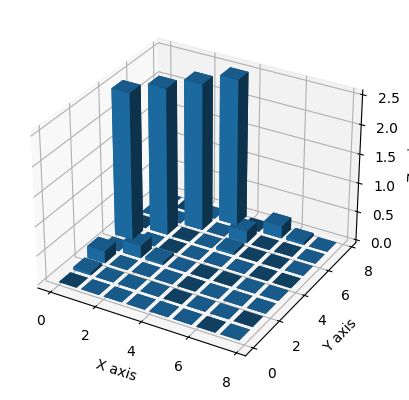

In [291]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

matrix = ss.rho

x = np.arange(matrix.shape[1])
y = np.arange(matrix.shape[0])
x, y = np.meshgrid(x, y)

x = x.ravel()
y = y.ravel()
z = np.zeros_like(x)

dx = dy = 0.8
dz = matrix.ravel()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.bar3d(x, y, z, dx, dy, dz, shade=True)

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

plt.show()


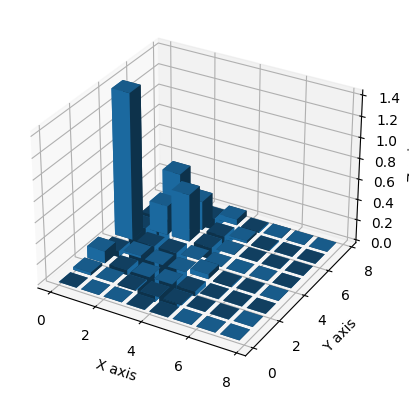

In [ ]:
x = np.arange(1, 200, 1)
y = []

ss_original = SpectraSequence(r'test', 'H', order, apply_mask=True)
initial_areas = np.array(ss_original.calculate_areas(peaks))

for iter in x:
    ss = SpectraSequence(r'test', 'H', order, apply_mask=True)
    ss.correct_baselines(iter)
    adjusted_areas = np.array(ss.calculate_areas(peaks))
    relative_difference = np.where(
        initial_areas != 0,
        abs((adjusted_areas - initial_areas) / initial_areas) * 100,
        np.nan
    )
    max_relative_difference = np.nanmax(relative_difference)
    y.append(max_relative_difference)

plt.plot(x, np.array(y))
plt.xlabel('Iterations')
plt.ylabel('Max Relative Difference (%)')
plt.grid()
plt.title('Max Relative Difference vs Iterations')
plt.show()

In [74]:
import numpy as np
from itertools import product



N = 3
basis_operator = Operator_basis(N)
basis_operator.set_transition_table(transition_table)
operator_name = ('z','y','x')
operator = basis_operator.get_operator(operator_name)
if operator is not None:
    print(f"Operator for {operator_name}:")
    print(operator)

    # Применение импульса
    pulse = 'yx1'  # Пример импульса
    new_name = basis_operator.apply_pulse(operator_name, pulse)
    print(f"New operator name after applying pulse: {new_name}")
    print('pulse applied: '+ f'{pulse}')
    print(basis_operator.get_operator(new_name))
else:
    print("Operator not found.")


Operator for ('z', 'y', 'x'):
[[ 0.+0.j  0.+0.j  0.+0.j  0.-8.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.-8.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+8.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+8.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j -0.+0.j -0.+0.j  0.+0.j  0.+8.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j -0.+0.j -0.+0.j  0.+8.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.-8.j -0.+0.j -0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.-8.j  0.+0.j -0.+0.j -0.+0.j]]
New operator name after applying pulse: ('-x', '-z', 'x')
pulse applied: yx1
[[ 0  0  0  0  0  8  0  0]
 [ 0  0  0  0  8  0  0  0]
 [ 0  0  0  0  0  0  0 -8]
 [ 0  0  0  0  0  0 -8  0]
 [ 0  8  0  0  0  0  0  0]
 [ 8  0  0  0  0  0  0  0]
 [ 0  0  0 -8  0  0  0  0]
 [ 0  0 -8  0  0  0  0  0]]


In [ ]:
from scipy import signal

def proper_phases(data, window):
    spectrum_unpr = np.fft.fft(window * data[0])
    spectrum, phases = ng.proc_autophase.autops(spectrum_unpr, 'acme', return_phases=True)
    return phases

def noize_spectra_idx(data):
    max_vals = []
    for i in range(len(data)):
        spectrum_unpr = np.fft.fft(data[i])
        maxima = max(np.real(spectrum_unpr))
        max_vals.append(maxima)
    threshold = np.mean(maxima) / 100
    indices = [i for i, value in enumerate(max_vals) if value < threshold]
    return indices



tn = 'C' # Название исследуемого ядра9

dic, data = ng.varian.read(r'test//C')
df = pd.read_csv('test//dict.csv')
filtered_df = df[df['nucleus'] == 'C']
at = float(dic['procpar']['at']['values'][0])
peak_width = filtered_df['peak_width'].values[0]
center = filtered_df['center'].values[0]
region = filtered_df['borders'].values[0]

window = 1
phases = proper_phases(data, window)
id_idx = noize_spectra_idx(data)
n = len(data[0])
time = np.linspace(0, at, n)
dt = at / n

frequencies = np.fft.fftfreq(n, d=dt)
dnu = frequencies[1] - frequencies[0]
peak_idx_width = int(peak_width / dnu)
mask = (frequencies >= center-region) & (frequencies <= center+region)
frequencies = frequencies[mask]

integrated_areas = []
fig, axs = plt.subplots(6, 4, figsize=(30, 50))
axs = axs.flatten()
spectras = []
peaks = []

for idx in range(len(data)):
    if idx not in id_idx and idx != 0:
        spectrum = np.fft.fft(window * (data[idx]))[mask]
        ph_corrected_spectrum = np.real(spectrum * np.exp(1j * 2 * np.pi / 360 * (phases[0])))
        normalized_spectrum = ph_corrected_spectrum / max(ph_corrected_spectrum)
        bl = baseline(ph_corrected_spectrum, 3)
        corrected_spectrum = ph_corrected_spectrum - bl
        loc_peaks = ng.analysis.peakpick.pick(normalized_spectrum, 0.3, -0.3, table=True)
        iter = 1
        area_indices = []
        for peak in loc_peaks:
            left = int(peak[0] - peak_idx_width)
            right = int(peak[0] + peak_idx_width)
            # area = simps(np.real(ph_corrected_spectrum[left:right]), frequencies[left:right])
            # integrated_areas.append([{'index':idx + 1}, {'integral_num': iter}, {'area':area}])
            iter += 1
        peaks.append(loc_peaks)
        spectras.append(corrected_spectrum)

for idx in range(len(spectras)):
    axs[idx].plot(frequencies, spectras[idx])
    for i in range(len(peaks[idx])):
        s = int(peaks[idx][i][0] + peak_idx_width)
        p = int(peaks[idx][i][0] - peak_idx_width)
        # axs[idx].axvline(x=frequencies[s], color='orange', linestyle='--')
        # axs[idx].axvline(x=frequencies[p], color='blue', linestyle='--')
plt.show()

Optimization terminated successfully.
         Current function value: 1062.591951
         Iterations: 96
         Function evaluations: 182


IndexError: index 24 is out of bounds for axis 0 with size 24